## Task 5, Part 1


"Power of two choices". Instead of throwing balls independently into bins, for each
ball we choose randomly d bins and check the number of balls inside. Then we place
the new ball in the bin (one of bins) with the smallest balls in the given moment. Check
experimentally, how parameter d influences random variables C, B and the maximal
load. Consider different d staring from 1. Note that the case d = 1 is just the regular
BiBa model.


<ul><li>We throw independently balls into n bins until there are two balls in a single bin (a
conflict). Let B be the number of thrown balls.</li></ul>

In [1]:
import numpy as np
from time import time
import numba
import timeit
from matplotlib import pyplot as plt

In [2]:
@numba.njit()
def choose_min_from_d_bins(array_with_bins, d):
    d_bins = np.random.choice(len(array_with_bins), size=d, replace=False)
    d_bins_count = array_with_bins[d_bins]
    array_with_bins[d_bins[d_bins_count.argmin()]] += 1
    return array_with_bins

In [3]:
@numba.njit()
def simulate_biba_until_conflict(num_of_bins, d):
    bins = np.zeros(num_of_bins)
    counter = 0
    while 2 not in bins:
        bins = choose_min_from_d_bins(bins, d)
        counter += 1
    return counter 

In [7]:
@numba.njit(parallel=True)
def repeat_conflict(num_of_bins, num_of_trials, d):
    results = np.zeros(num_of_trials)
    for i in numba.prange(num_of_trials):
        results[i] = simulate_biba_until_conflict(num_of_bins, d)
    return results

In [4]:
def get_optimal_number_of_bins_for_histogram(histogram):
    stddev = np.std(histogram)
    n = len(histogram)
    width = (3.5 * stddev) / (n ** (1/3))
    range_of_data = histogram.max() - histogram.min()
    return int(np.ceil(range_of_data / width))

In [5]:
d = 30
number_of_bins = 100
number_of_trials = 10000

In [6]:
%%timeit 
simulate_biba_until_conflict(number_of_bins, d)

160 µs ± 9.26 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [8]:
%%timeit
repeat_conflict(number_of_bins, number_of_trials, d)

247 ms ± 23.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [9]:
number_of_bins = 500
number_of_trials = 10000
d_parameters = [1, 5, 10, 20, 50]
histograms = []
times = []

In [11]:
for d in d_parameters:
    time1 = time()
    histograms.append(repeat_conflict(number_of_bins, number_of_trials, d))
    time2 = time()
    times.append(round(time2 - time1, 5))
print(*times)

0.2845 2.0955 3.1025 4.0785 4.446


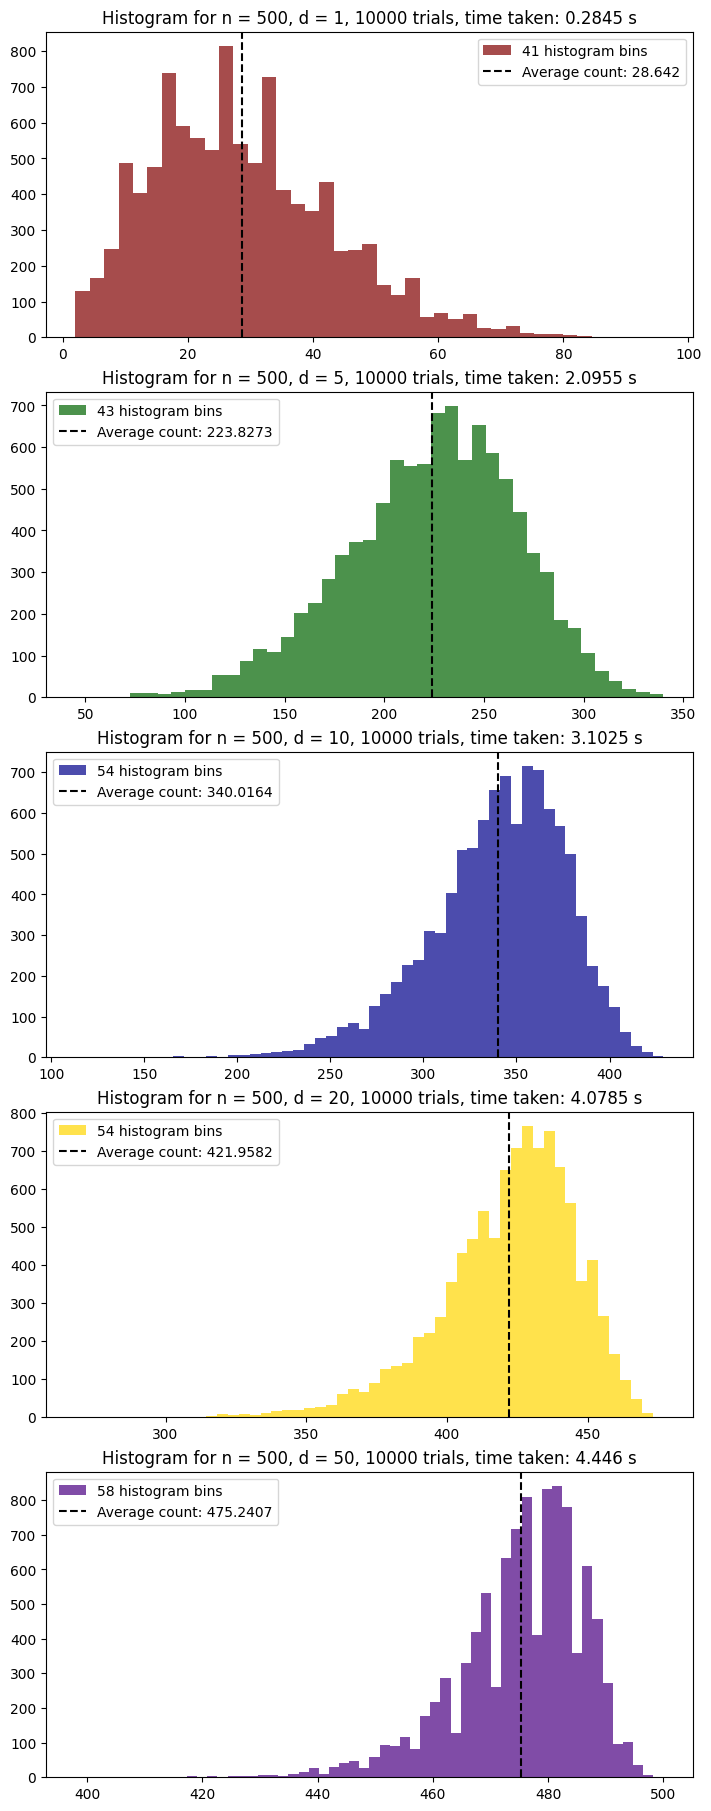

In [12]:
figure1, axes1 = plt.subplots(len(d_parameters), 1, layout='constrained', figsize=(7, 18))

colors = ['maroon', 'darkgreen', 'darkblue', 'gold', 'indigo']
for index, (d, histogram, time_, color) in enumerate(zip(d_parameters, histograms, times, colors)):
    mean_value = histogram.mean()
    histogram_bins = get_optimal_number_of_bins_for_histogram(histogram)
    axes1[index].hist(histogram, 
                      color=color, 
                      alpha=0.7, 
                      bins=histogram_bins, 
                      label=f'{histogram_bins} histogram bins')
    axes1[index].axvline(mean_value, 
                         color='black', 
                         linestyle='--', 
                         label=f'Average count: {mean_value}')
    title = f'Histogram for n = {number_of_bins}, d = {d}, {number_of_trials} trials, time taken: {time_} s'
    axes1[index].set(title=title)
    axes1[index].legend()

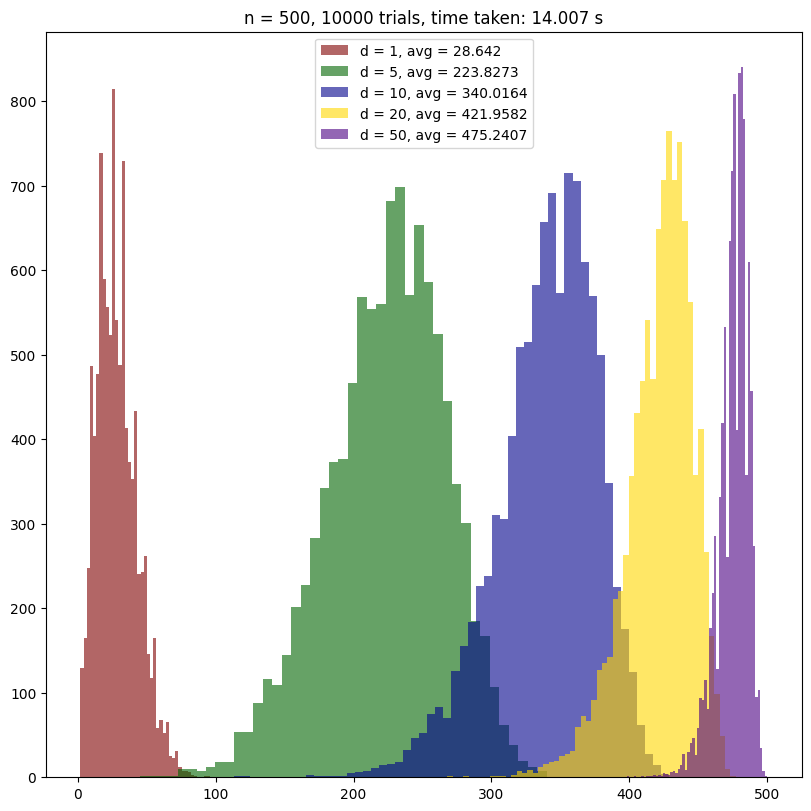

In [13]:
figure2, axes2 = plt.subplots(1, 1, layout='constrained', figsize=(8, 8))

for index, (d, histogram, color) in enumerate(zip(d_parameters, histograms, colors)):
    mean_value = histogram.mean()
    histogram_bins = get_optimal_number_of_bins_for_histogram(histogram)
    axes2.hist(histogram, 
               color=color, 
               alpha=0.6, 
               bins=histogram_bins, 
               label=f'd = {d}, avg = {mean_value}')
    title = f'n = {number_of_bins}, {number_of_trials} trials, time taken: {round(np.array(times).sum(), 3)} s'
    axes2.set(title=title)
    axes2.legend()

In [14]:
def repeat_conflict_for_range(num_of_bins, num_of_trials, d_range):
    results = np.zeros(len(d_range))
    times = np.zeros(len(d_range))
    for i, d in enumerate(d_range):
        time1 = time()
        results[i] = repeat_conflict(num_of_bins, number_of_trials, d).mean()
        time2 = time()
        times[i] = round(time2 - time1, 5)
    return results, times

In [15]:
number_of_trials = 100
d_array = np.arange(1, 40, 1)
n_list = [500, 200, 150, 100, 80]
d_list = []
time_list = []

In [17]:
for n in n_list:
    d_function, d_time = repeat_conflict_for_range(n, number_of_trials, d_array)
    d_list.append(d_function)
    time_list.append(d_time)

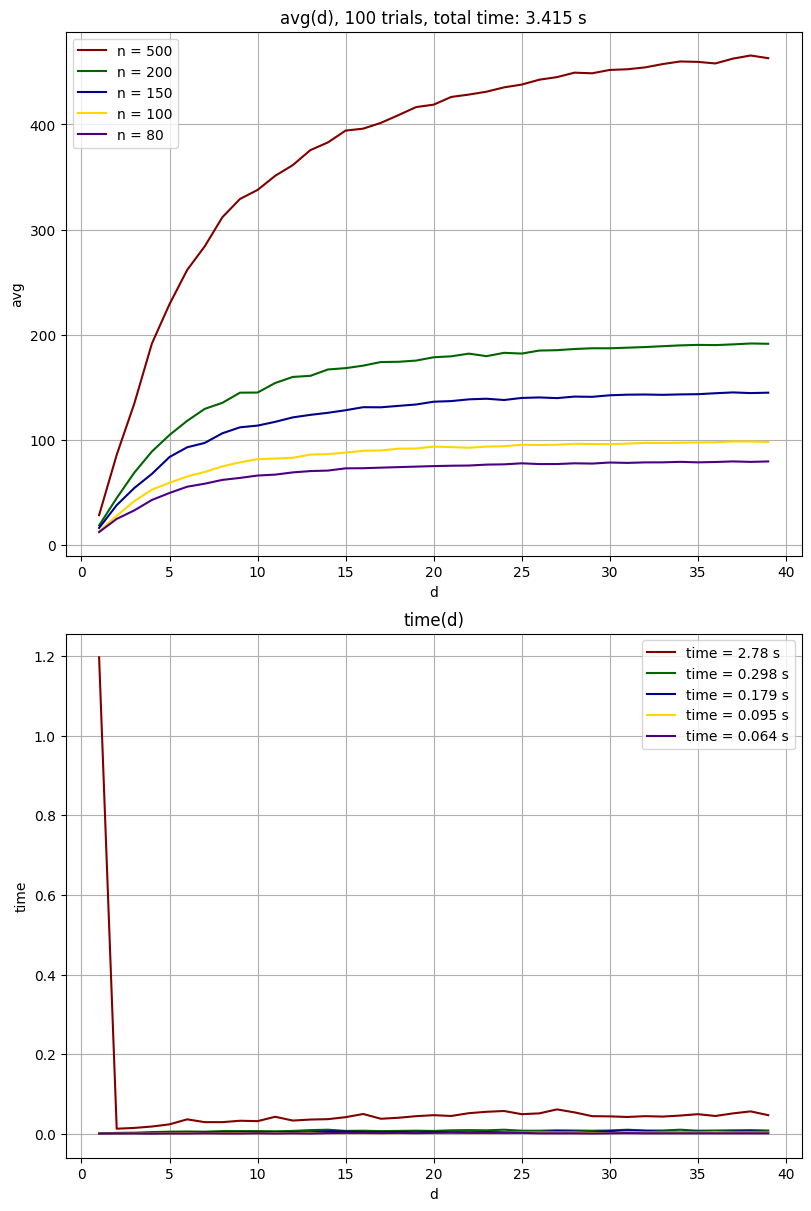

In [18]:
figure3, axes3 = plt.subplots(2, 1, layout='constrained', figsize=(8, 12))
total_time = sum(list(map(np.sum, time_list)))

for index, (d_function, d_time, n, color) in enumerate(zip(d_list, time_list, n_list, colors)):
    axes3[0].plot(d_array, d_function, color=color, label=f'n = {n}')
    axes3[1].plot(d_array, d_time, color=color, label=f'time = {round(d_time.sum(), 3)} s')
axes3[0].set(title=f'avg(d), {number_of_trials} trials, total time: {round(total_time, 3)} s', 
             xlabel='d', 
             ylabel='avg')
axes3[1].set(title=f'time(d)', xlabel='d', ylabel='time')
axes3[0].legend()
axes3[1].legend()
axes3[0].grid()
axes3[1].grid()